In [2]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
import pmdarima as pm
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
%matplotlib inline

from processing import Stationarizer, Normalizer
#from tuner import LSTMLayerHyperparams, ModelHyperparams
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner

2024-08-09 10:38:40.666479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model = keras.Sequential()    
model.add(keras.Input(
      shape=(20, 1),
      batch_size=64,
      name="Inputs"
))
model.add(layers.Dense(32, activation="linear", kernel_initializer="orthogonal"))
model.add(
    layers.LSTM(
        units=32,
        activation="linear",
        recurrent_activation="sigmoid",
        dropout=0.400637,
        recurrent_dropout=0.046802,
        return_sequences=True
    )
)
model.add(
    layers.LSTM(
        units=32,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.409050,
        recurrent_dropout=0.110162,
        return_sequences=False
    )
)
model.add(
    layers.Dense(
        1,
        activation="linear",
        kernel_initializer="he_normal"
    )
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000095),
    loss="mse",
    metrics=["mse"],
)

In [9]:
data = pd.read_csv("data/YF_TSLA.csv")["Adj Close"].to_numpy().reshape(-1, 1)

normer = Normalizer()
normer.fit(data)

train_idx = int(0.7 * np.shape(data)[0])
val_idx = int(0.85 * np.shape(data)[0])

train_data = data[:train_idx]
val_data = data[train_idx:val_idx]
non_test_data = data[:val_idx]
test_data = data[val_idx:]

train_data = normer.transform(train_data)
val_data = normer.transform(val_data)

train_ds = timeseries_dataset_from_array(
    train_data[:-20],
    train_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=True
)
val_ds = timeseries_dataset_from_array(
    val_data[:-20],
    val_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=True
)

In [10]:
chkpt_path = "checkpoints/model_1-4/model_checkpoint.weights.keras"
chkpt_cb = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=chkpt_path,
    verbose=1,
    save_best_only=True
)

es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=20)

history = model.fit(
    train_ds,
    epochs=200,
    validation_data=val_ds,
    callbacks=[chkpt_cb, es_cb]
)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3843 - mse: 0.3843
Epoch 1: val_loss improved from inf to 2.61968, saving model to checkpoints/model_1-4/model_checkpoint.weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3831 - mse: 0.3831 - val_loss: 2.6197 - val_mse: 2.6197
Epoch 2/200
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1988 - mse: 0.1988
Epoch 2: val_loss improved from 2.61968 to 2.15266, saving model to checkpoints/model_1-4/model_checkpoint.weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1966 - mse: 0.1966 - val_loss: 2.1527 - val_mse: 2.1527
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0563 - mse: 0.0563
Epoch 3: val_loss improved from 2.15266 to 1.92113, saving model to checkpoints/model_1-4/model_checkpoint.weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0559 - mse: 0.0559 - val_loss: 1.9211 - val_mse: 1.9211
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0303 - mse: 0.0303

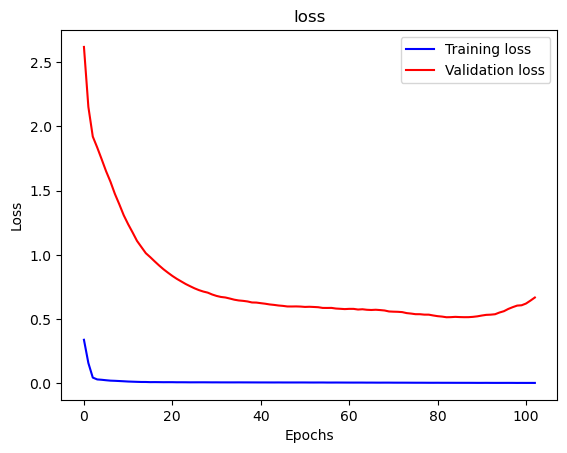

In [11]:
visualize_loss(history, "loss")

In [12]:
model.load_weights(chkpt_path)

In [13]:
preds = []

for x, y in val_ds:
    #print(x.shape)
    #print(y.shape)
    #print(model.predict(x).shape)
    yhat = model.predict(x)
    for el in range(x.shape[0]):
        preds.append([x[el], y[el], yhat[el]])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


2024-08-09 10:48:05.746512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
#preds = np.array(preds)
y = np.array([float(el[1]) for el in preds])
yhat = np.array([el[2] for el in preds])

In [15]:
y_r = normer.inverse_transform(y)
yhat_r = normer.inverse_transform(yhat)

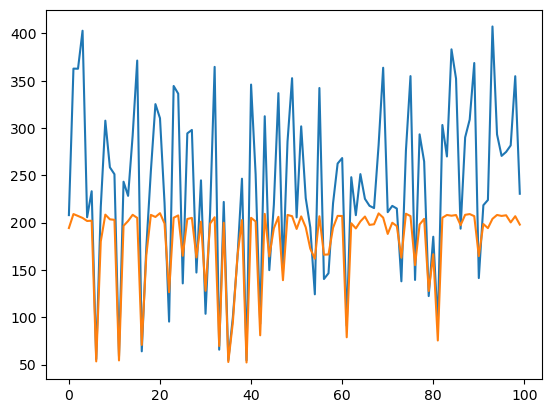

In [16]:
x = np.arange(490)
y_r = y_r.flatten()
yhat_r = yhat_r.flatten()

plt.plot(np.arange(100), y_r[:100])
plt.plot(np.arange(100), yhat_r[:100])

In [17]:
max(yhat)

array([1.3275958], dtype=float32)

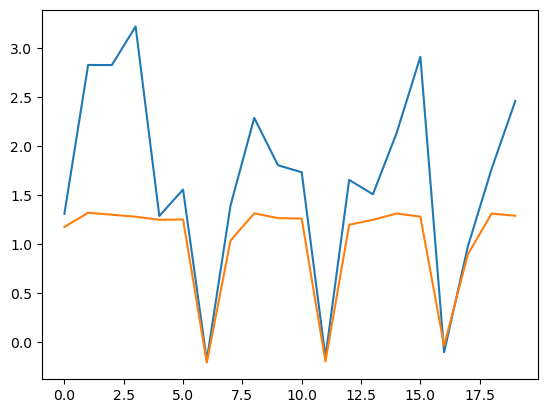

In [18]:
x = np.arange(490)
plt.plot(x[:20], y[:20])
plt.plot(x[:20], yhat[:20])
plt.figsize=(12, 10)

/home/lucas/mambaforge/envs/ece539/lib/python3.11/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


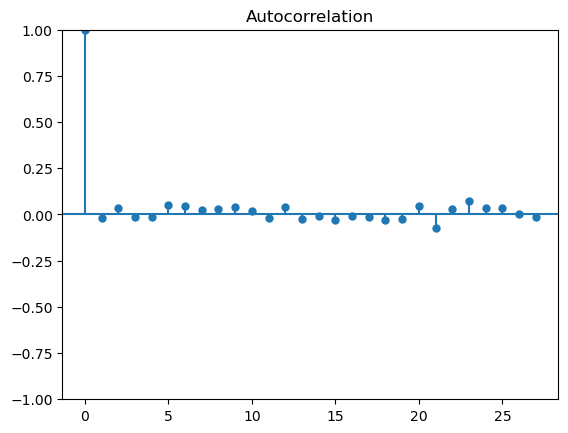

In [19]:
pm.plot_acf(y)

In [20]:
stepwise_fit = pm.auto_arima(y_r.flatten(), start_p=1, start_q=1, max_p=3, max_q=3, d=1, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6101.371, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5944.142, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6099.373, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5895.774, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5868.933, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5866.930, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5893.772, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.066 seconds


In [21]:
arima.summary()

NameError: name 'arima' is not defined

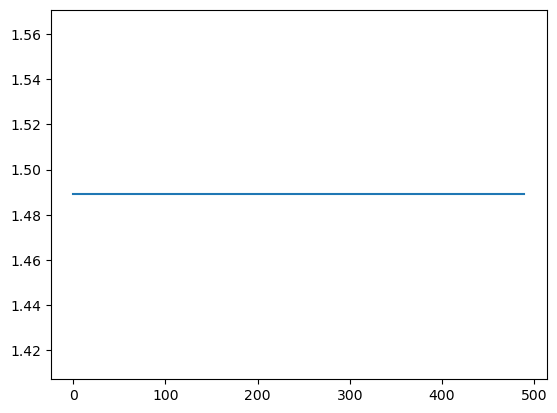

In [67]:
#plt.scatter(x[:30], y[:30], marker="x")
plt.plot(x, arima.predict(490))